In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
from tqdm import tqdm
import sys
sys.path.append('/home/icb/manuel.gander/Atl/notebooks/')
import utils
utils = importlib.reload(utils)
import scipy


import warnings
from scipy.stats import ConstantInputWarning
from sklearn.exceptions import ConvergenceWarning

# Ignore ConstantInputWarning
warnings.filterwarnings("ignore", category=ConstantInputWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import ElasticNet

In [43]:
alpha = 0.03
l1_ratio = 0.9
data='RNA'
kn = 10**6
source = 'GDSC2'

reps=50

In [44]:
D_prot, features, celllines = utils.load_dataset(data)
dfv = utils.prep_viability_AUCs2(D_prot)
dfv = dfv[dfv['Source']==source].copy()

 67%|████████████████████████████████████████████████████████████████▏                               | 880/1315 [00:35<00:17, 25.10it/s]


KeyboardInterrupt: 

In [5]:
drug = '131634760'

In [6]:
dfvs=dfv[dfv['PubChem_CID']==drug].copy()

In [7]:
len(dfvs['Cello'])

485

In [8]:
D_holdout = utils.get_holdouts_balanced(dfvs, reps)

In [27]:
ws = []
yts = []
yps = []
for hs in range(reps):
    holdouts=D_holdout[hs]
    dfv0, dfh=utils.split_of_validation_cell_lines(dfvs, ccls=holdouts)
    train_input=utils.dfv_to_train_arrays(dfv0, D_prot)
    mean = train_input[1].mean()

    rss1 = utils.paerson_nb(train_input[0], train_input[1])

    hold_input=utils.dfv_to_train_arrays(dfh, D_prot)
    
    if kn<len(rss1):
        r_kept=np.argsort(rss1)[-kn:]
        X_kept=train_input[0][:,r_kept]
        Xh_kept=hold_input[0][:,r_kept]
    else:
        #print('all kept')
        X_kept=train_input[0]
        Xh_kept=hold_input[0]
    y_train=train_input[1]
    y_test = hold_input[1]
                                  
    regr = ElasticNet(random_state=0, alpha=alpha, l1_ratio=l1_ratio)
    regr.fit(X_kept, y_train)
    
    prediction = regr.predict(Xh_kept)
    yts.append(y_test)
    yps.append(prediction)
    ws.append(regr.coef_)

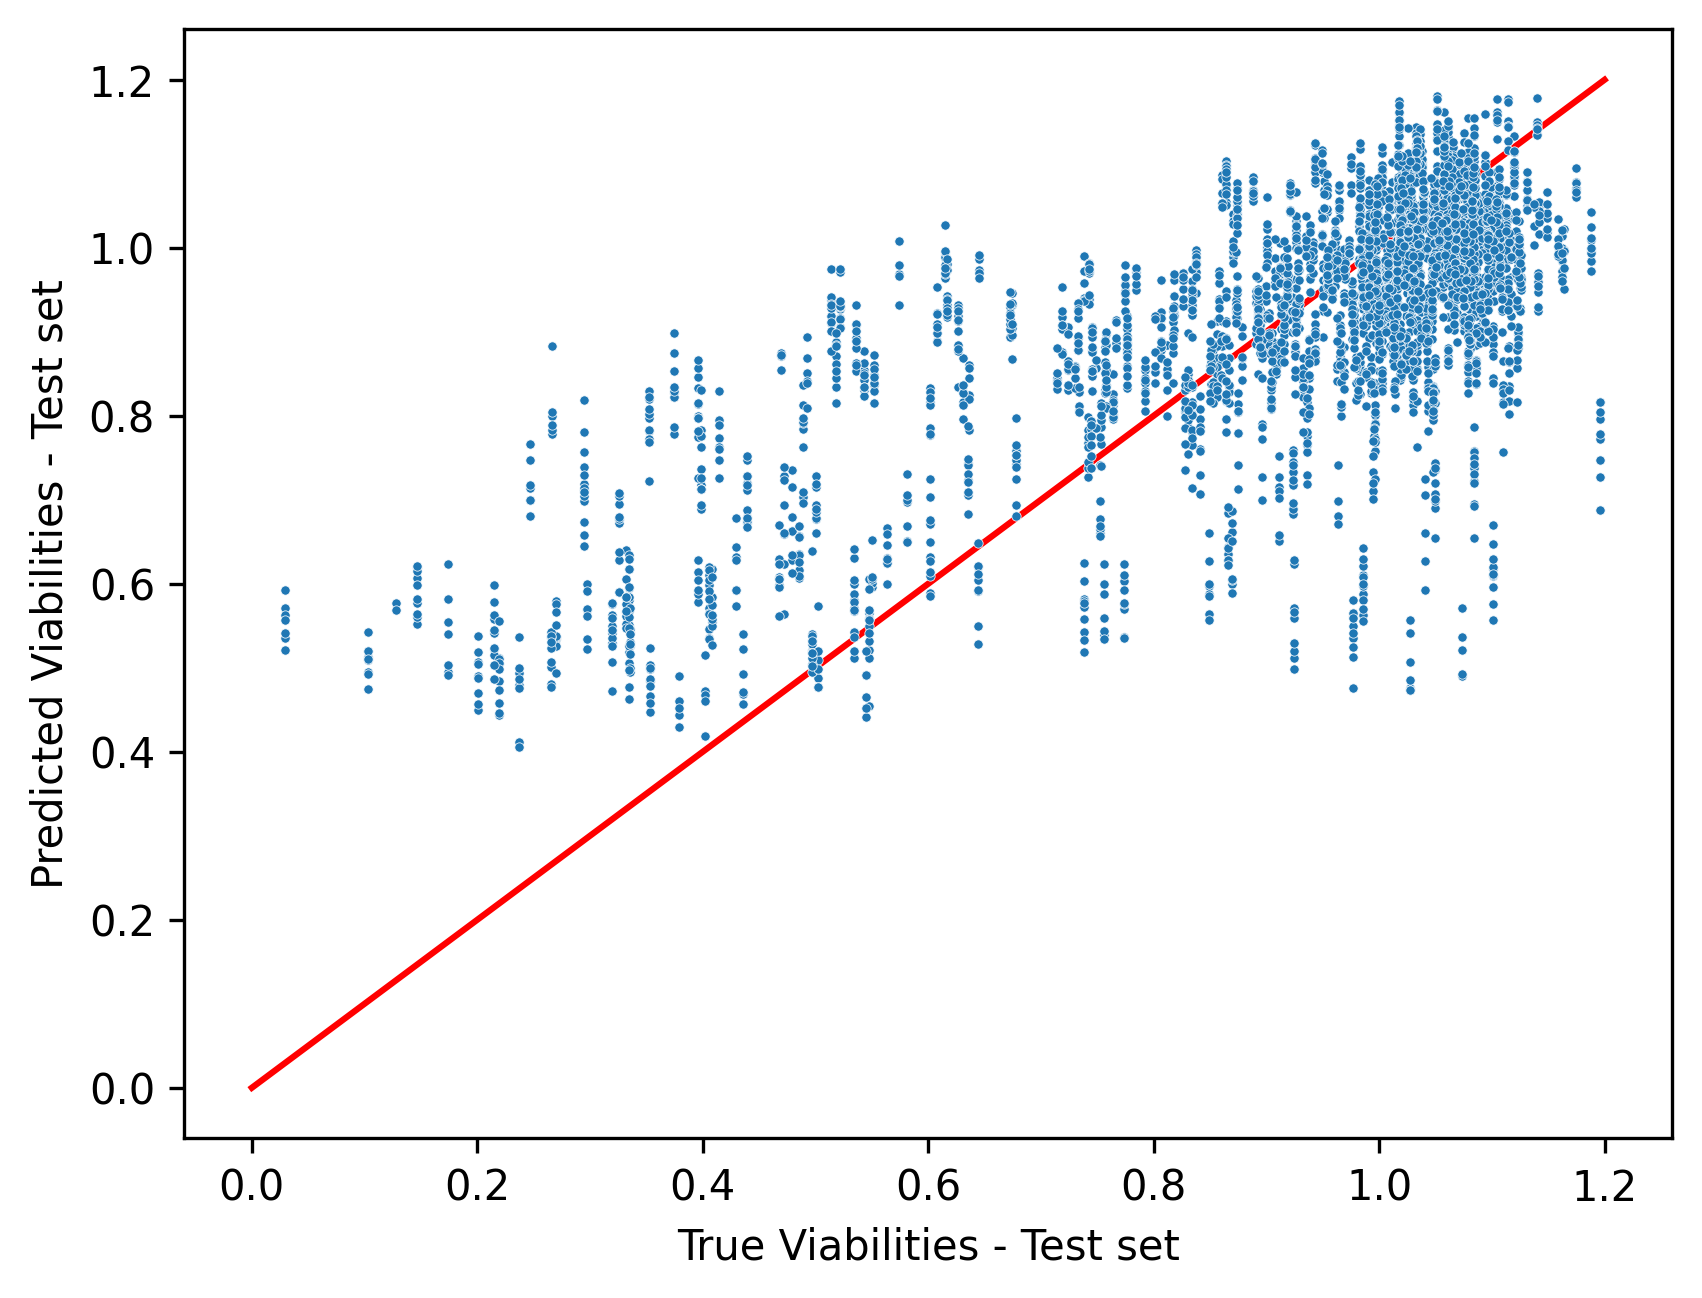

In [38]:
sns.scatterplot(x=np.concatenate(yts), y=np.concatenate(yps), s=5)
plt.xlabel('True Viabilities - Test set')
plt.ylabel('Predicted Viabilities - Test set')
plt.plot([0,1.2], [0,1.2], c='r', zorder=-1)

In [40]:
scipy.stats.pearsonr(np.concatenate(yts), np.concatenate(yps))

PearsonRResult(statistic=0.7293916017981966, pvalue=0.0)

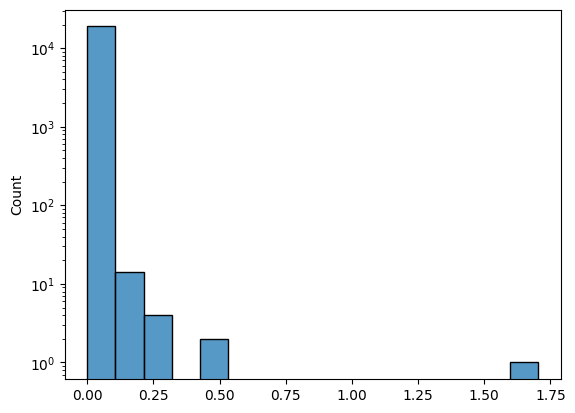

In [19]:
W = np.vstack(ws)
W = pd.DataFrame(data=W, columns = features)
sns.histplot(list(abs(W).sum()))
plt.yscale('log')
vc = abs(W).sum()
Ws = W[vc[vc>0.2].index]

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'CNN3'),
  Text(1.5, 0, 'IGJ'),
  Text(2.5, 0, 'LGALS3BP'),
  Text(3.5, 0, 'WBP5'),
  Text(4.5, 0, 'BCL2L1'),
  Text(5.5, 0, 'S100A8'),
  Text(6.5, 0, 'GDF15')])

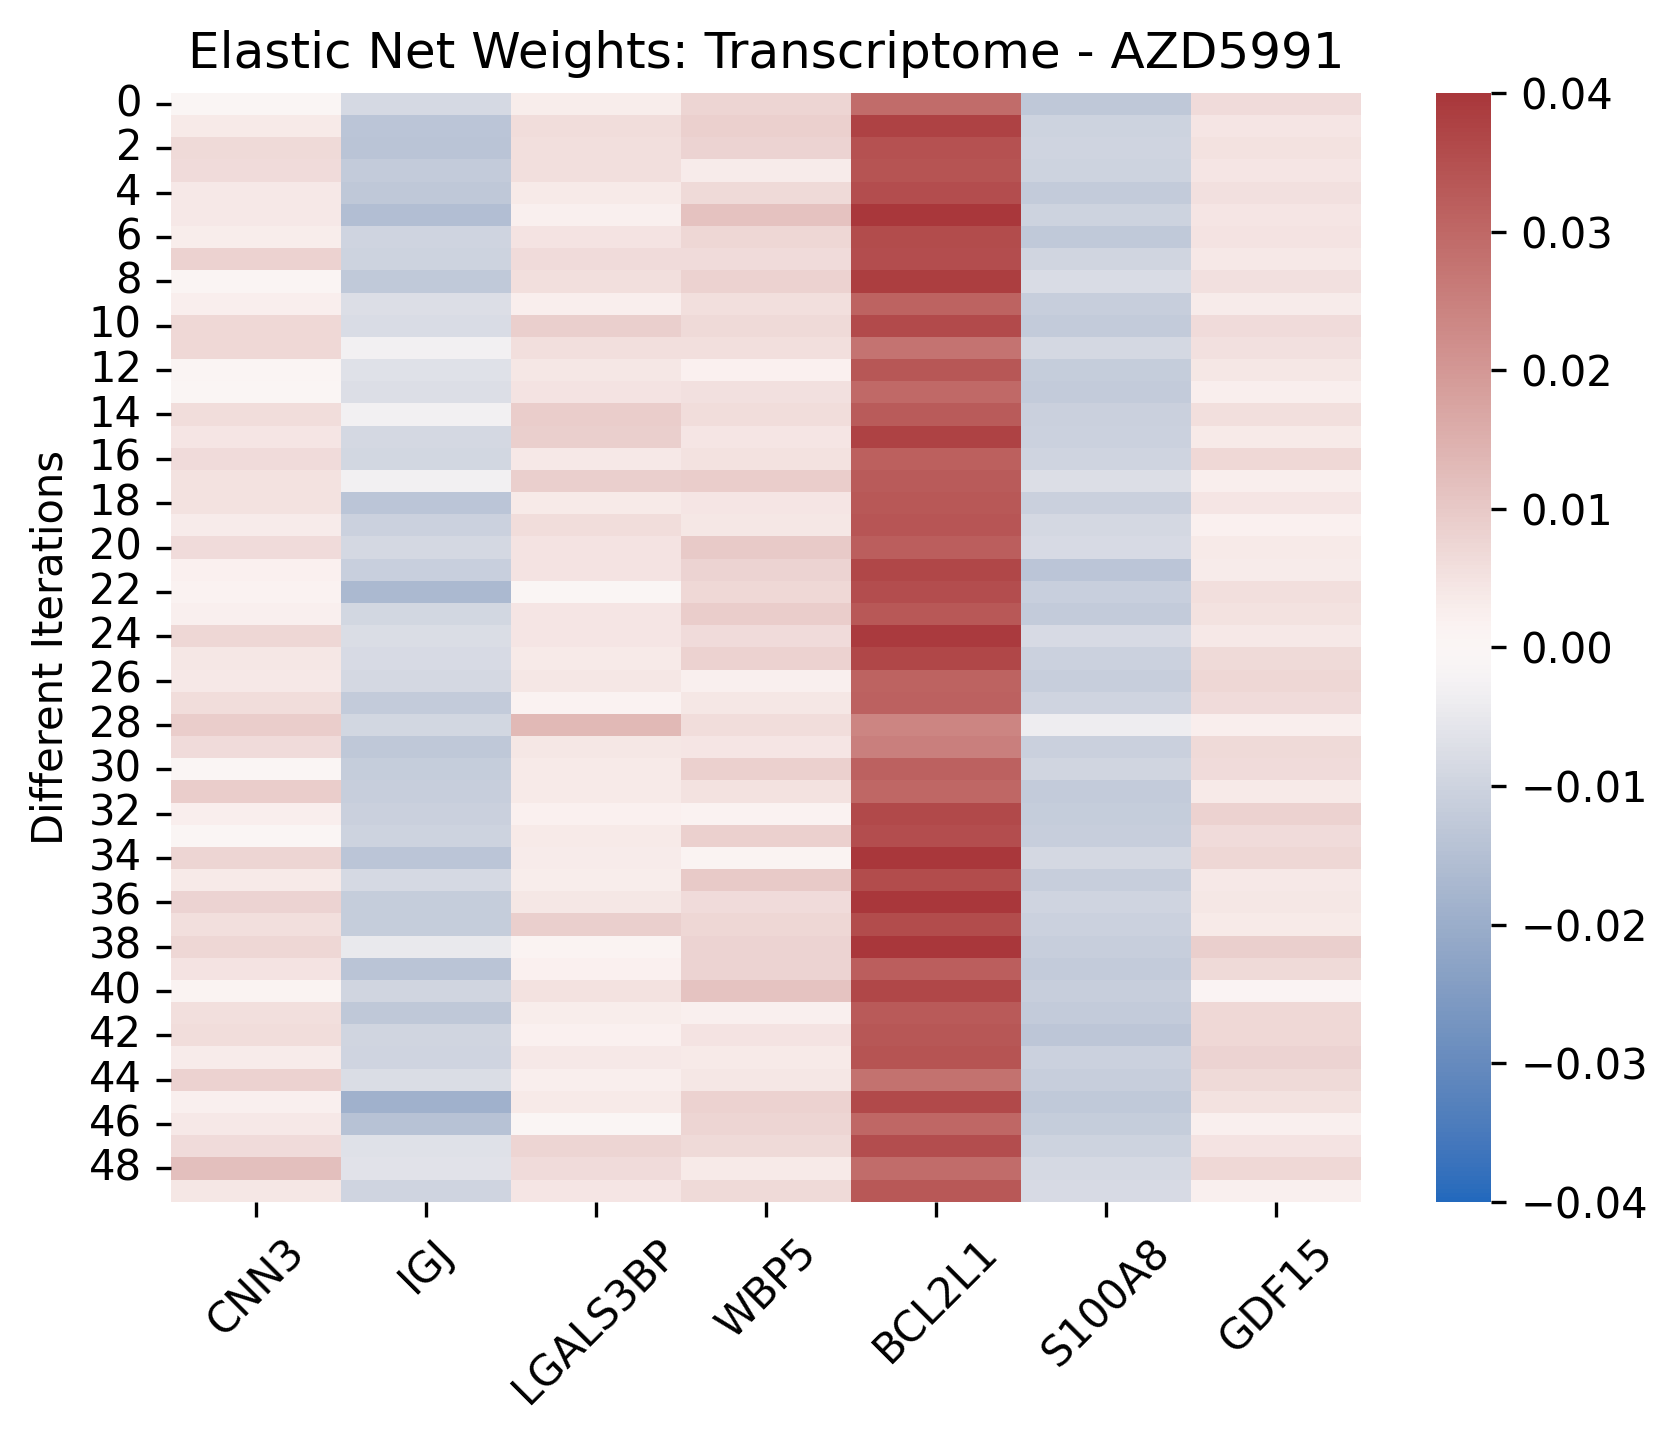

In [26]:
plt.rcParams['figure.dpi'] = 300
lims = 0.04
sns.heatmap(Ws, cmap='vlag', vmin=-lims, vmax=lims)
plt.ylabel('Different Iterations')
plt.title('Elastic Net Weights: Transcriptome - AZD5991')
plt.xticks(rotation=45)

In [ ]:
AZD5991 is a potent and direct inhibitor of Mcl-1 with high selectivity versus other Bcl-2 family proteins. AZD5991 binds directly to Mcl-1 and induces rapid

In [ ]:
BCL2L1 inhibitor A-1331852 inhibits MCL1 transcription and triggers apoptosis in acute myeloid leukemia cells